In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder #responsible for loading images from train and test folders
from torch.utils.data import DataLoader, random_split # Definition of iterable
from torchvision import transforms, models # Provides image transformations
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_score, recall_score

from config import *
import shutil
import seaborn as sns
import random
import cv2
from tensorflow.keras.preprocessing import image 
from PIL import Image


import mlflow.pytorch
import mlflow
from mlflow import MlflowClient
from datetime import datetime
import time

In [2]:
DATASET_PATH

'../data/PKLot/PKLotSegmented_rearranged/PUC/Sunny/'

### Get data

In [12]:
# if not os.path.exists(os.path.join(DATASET_PATH,'Empty')):
# 		os.makedirs(os.path.join(DATASET_PATH,'Empty'))
# if not os.path.exists(os.path.join(DATASET_PATH,'Occupied')):
# 		os.makedirs(os.path.join(DATASET_PATH,'Occupied'))


In [2]:
daylist = os.listdir(DATASET_PATH_RAW)
labels = ['Empty','Occupied']


In [3]:
for label in labels:
    print(label)


Empty
Occupied


In [15]:
# for day in daylist:
#     for label in labels:
#         daypath = os.path.join(DATASET_PATH_RAW,day)
#         path = os.path.join(daypath,label)
#         destpath =  os.path.join(DATASET_PATH,label)
#         if os.path.exists(path):
#             filelist = os.listdir(path)
#             for file in filelist:
#                 filepath = os.path.join(path,file)
#                 shutil.copy(filepath,destpath)
#         else:
#             print(f'path {path} empty')

                

path ../data/PKLot/PKLotSegmented/PUC/Sunny/2012-10-30/Empty empty
path ../data/PKLot/PKLotSegmented/PUC/Sunny/2012-11-07/Empty empty
path ../data/PKLot/PKLotSegmented/PUC/Sunny/2012-11-06/Empty empty


In [4]:
emptylist= os.listdir(os.path.join(DATASET_PATH,'Empty'))
occupiedlist = os.listdir(os.path.join(DATASET_PATH,'Occupied'))

In [23]:
# Data for sample testing.
trainpath = os.path.join(DATASET_PATH_RAW,'2012-09-13')
testpath = '../data/PKLot/PKLotSegmented/PUC/Cloudy/2012-10-28'
valpath = '../data/PKLot/PKLotSegmented/PUC/Rainy/2012-10-25'

In [20]:
# Data for full training

# trainpath = os.path.join(DATASET_PATH,'train')
# testpath = os.path.join(DATASET_PATH,'test')
# valpath = os.path.join(DATASET_PATH,'val')

In [58]:

# if not os.path.exists(trainpath):
#     os.makedirs(trainpath)
#     os.makedirs(os.path.join(trainpath,'Empty'))
#     os.makedirs(os.path.join(trainpath,'Occupied'))
   
# if not os.path.exists(testpath):
# 	os.makedirs(testpath)
# 	os.makedirs(os.path.join(testpath,'Empty'))
# 	os.makedirs(os.path.join(testpath,'Occupied'))

# if not os.path.exists(valpath):
# 	os.makedirs(valpath)
# 	os.makedirs(os.path.join(valpath,'Empty'))
# 	os.makedirs(os.path.join(valpath,'Occupied'))
  


In [35]:
# Train Val Test split.

# #for path, subdirs, files in os.walk(root):
# for label in labels:
#     path =  os.path.join(DATASET_PATH,label)
#     random.seed(42)
#     filelist = os.listdir(path)
#     random.shuffle(filelist)
    
#     train_size = int(len(filelist) * 0.70)
#     val_size = int(len(filelist) * 0.15)
#     test_size = int(len(filelist) * 0.15)
    
#     #Creating train data
#     for file in filelist[0:train_size]:
#         filepath = os.path.join(path,file)
#         shutil.copy(filepath,os.path.join(trainpath,label))
        
#     #Creating val data
#     for file in filelist[train_size:(train_size + val_size )]:
#         filepath = os.path.join(path,file)
#         shutil.copy(filepath,os.path.join(valpath,label))
        
#     #Creating test data
#     for file in filelist[train_size + val_size: (train_size + val_size + test_size )]:
#         filepath = os.path.join(path,file)
#         shutil.copy(filepath,os.path.join(testpath,label))

# EDA

- Check number of pictures per dataset.
- Check size of pictures
- Distribution with weather.
- Pro Bild wie viele Parking spaces.

/var/folders/2n/6g_5z31502qdn2b96gy2sss00000gn/T/ipykernel_92479/2948390238.py:22: RuntimeWarning: invalid value encountered in cast
  transformed_image = (transformed_image.numpy().transpose((1, 2, 0)) * 255).astype('uint8')


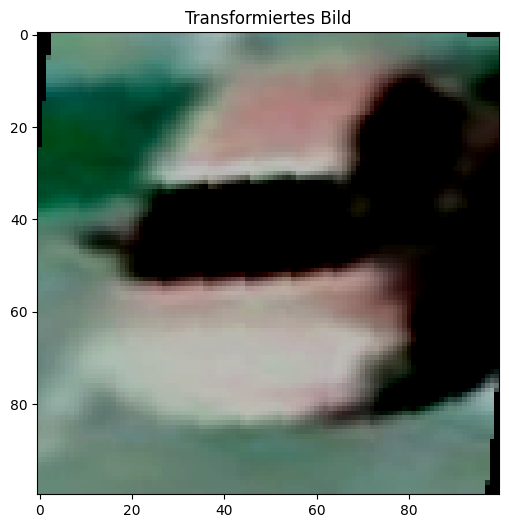

In [7]:
# Plotting the transformed image.

image_path = '../data/PKLot/PKLotSegmented_rearranged/PUC/Sunny/Occupied/2012-09-11_15_16_58#001.jpg'

# Bild einlesen
image = cv2.imread(image_path)

# Definition der Transformationen
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128), interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Anwendung der Transformationen
transformed_image = data_transform(image)

# Umwandlung von Tensor in NumPy-Array und Rückkehr der Werte auf den Bereich [0, 255]
transformed_image = (transformed_image.numpy().transpose((1, 2, 0)) * 255).astype('uint8')

# Bild anzeigen
plt.figure(figsize=(6, 6))
plt.imshow(transformed_image)
plt.title('Transformiertes Bild')
plt.show()

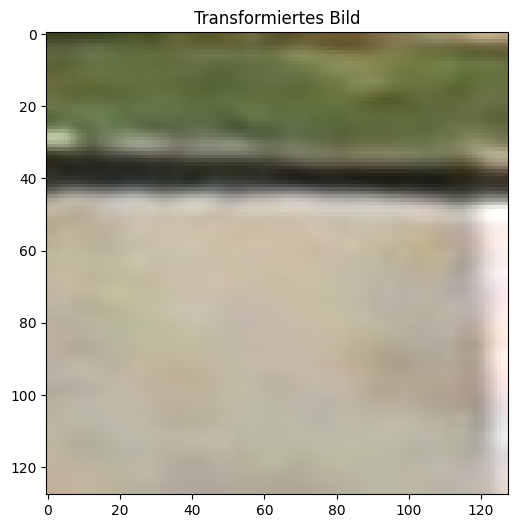

In [43]:
trainBatch = next(iter(trainDataLoader))
# Ehy do we need to transpose, multiply etc.
image = (trainBatch[0][0].numpy().transpose((1, 2, 0)) * 255).astype('uint8') # transpose and 255 are mandatory here.

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Transformiertes Bild')
plt.show()

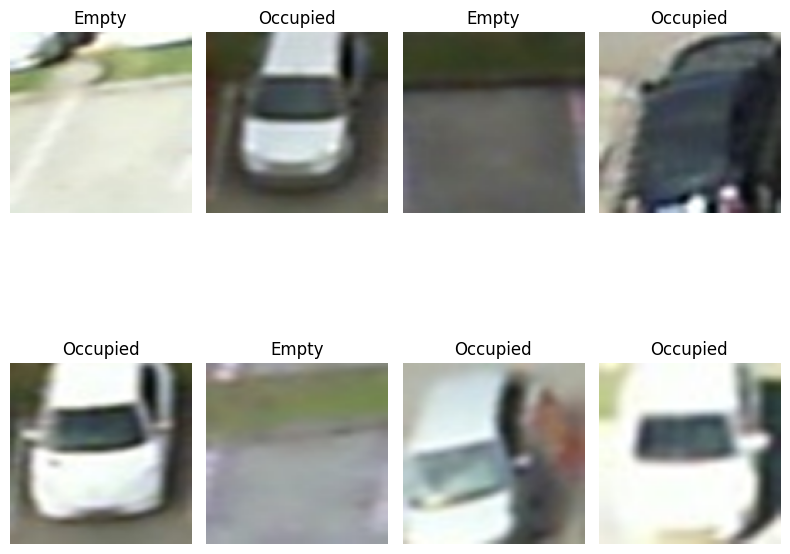

In [21]:
# Vizualization doesn't work yet.
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(BATCH_SIZE, BATCH_SIZE))
	# loop over the batch size
	for i in range(0, BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		# Convert the image from BGR to RGB (OpenCV uses BGR by default)
		
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
     	# grab the label id and get the label from the classes list
		image = (image * 255.0).astype("uint8")
		idx = batch[1][i]
		label = classes[idx]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()
 
trainBatch = next(iter(trainDataLoader))
visualize_batch(trainBatch, trainDataset.classes, "train")

In [8]:
print(len(emptylist))
len(occupiedlist)


111626


96761

<Axes: >

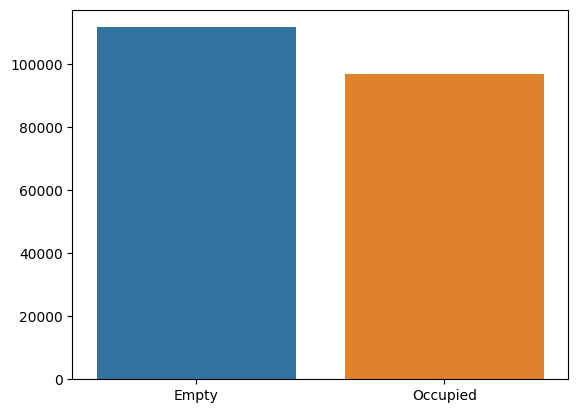

In [9]:
sns.barplot(x=labels, y =[len(emptylist), len(occupiedlist)])
# Numbers of classes almost equal.


# Models

In [24]:
# Dataloader in pytorch
# Imagefolder expects the class to be in the foldername.

# To-Do: Define transformations to be done. 
# Flip
# Rescale of values to 0,1
# shear range 
# zoomrange

trainTransfo = transforms.Compose([
    transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(), #totensor transforms a numpy array to a pytorch tensor. Also changes the value from [0,255] to [0,1]
# This code is beneficial if different trafos shall happen on the datasets. 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
trainDataset = ImageFolder(root=trainpath,
        transform=trainTransfo)
valDataset = ImageFolder(root=valpath, 
        transform=trainTransfo)
testDataset = ImageFolder(root=testpath, 
        transform=trainTransfo)


trainDataLoader = DataLoader(trainDataset, 
        batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testDataset, batch_size=BATCH_SIZE)

# # If no different trafos must happen the pictures can be split automatically in train, test and val dataset without creating the folders.
# dataset_size = len(dataset)
# train_size = int(0.7 * dataset_size)
# val_size = int(0.15 * dataset_size)
# test_size = dataset_size - train_size - val_size

#train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [7]:


TRACKING_URI = open("../.mlflow_uri").read().strip()
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.end_run()
# client = MlflowClient(tracking_uri=TRACKING_URI)

# all_experiments = client.search_experiments()

# print(all_experiments)


In [25]:


# Setzen Sie den Zufallsgenerator für die Reproduzierbarkeit
torch.manual_seed(42)

# Daten-Transformationen
data_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Laden Sie den Datensatz
dataset = ImageFolder('../data/PKLot/PKLotSegmented_rearranged/PUC/Sunny/', transform=data_transform)

# Aufteilung in Trainings-, Validierungs- und Testsets
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split only in folders where the data is sorted by label. There should be no additional folders like train, test -folder.
# Otherwise these additional folders will be concidered as labels.
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Data Loader erstellen
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


# Baseline model
- metric: accuracy. To-Do: Track metric
- track params.
- track artifacts

In [47]:
# Modell definieren (Beispiel: ResNet18)
model = models.resnet18(pretrained=True)
# Anpassung des Klassifikationskopfes an Ihre Klassenanzahl
model.fc = nn.Linear(model.fc.in_features, 2)  # Annahme: 2 Klassen (Empty, Occupied)

# Loss-Funktion und Optimizer wählen
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialisieren von MLflow
import mlflow
from datetime import datetime

# Erstellen Sie einen eindeutigen Namen für das Experiment
experiment_name = "ResNet_second_try" + datetime.now().strftime("%Y%m%d%H%M%S")
# Starten Sie das MLflow-Run
mlflow.set_experiment(experiment_name)
mlflow.start_run()

# Training durchführen
num_epochs = 10
for epoch in range(num_epochs):
    # Trainingsphase
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Loggen der Trainingsmetrik
        mlflow.log_metric("train_loss", loss.item())

    # Validierungsphase
    model.eval()
    val_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Loggen der Validierungsmetrik
        mlflow.log_metric("val_loss", val_loss)

# Speichern Sie das Modell in MLflow
mlflow.pytorch.log_model(model, artifact_path="ResNet_second_try")

# Beenden Sie den MLflow-Run
mlflow.end_run()

2024/01/15 18:12:28 INFO mlflow.tracking.fluent: Experiment with name 'ResNet_second_try20240115181228' does not exist. Creating a new experiment.


IndexError: Target 3 is out of bounds.

# Other model
- MobileNet paper metrics: Accuracy and Auc Score.

In [8]:
mlflow.end_run()

In [22]:
model = models.mobilenet_v3_small(pretrained = True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)

In [9]:
#check for gpu
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")
   
   # Check if GPU is available.
print(torch.backends.mps.is_available()) 
print(torch.backends.mps.is_built()) #MPS is activated

tensor([1.], device='mps:0')
True
True


In [10]:
print(torch.cuda.is_available())

False


In [23]:
model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=2, bias=True)
)

In [14]:
# Helper function to save confusion matrix as a text file
def save_confusion_matrix(cm, epoch):
    filename = f"confusion_matrix_epoch_{epoch}.txt"
    with open(filename, "w") as file:
        file.write("Confusion Matrix:\n")
        file.write(str(cm))
    return filename

In [15]:
mlflow.end_run()
# Took 853 = 14.2h Minutes to run through the first epoch of traindata.
# To read val dataset and make predictions and to save them takes 14.5 min.

# Setting to use GPU instead of CPU.
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = mps_device
# Modell definieren (Beispiel: ResNet18)
model = models.mobilenet_v3_small(pretrained = True).to(device)  
# Modification of the classifier part.
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2) # model.classifier[3] refers to the layer of the classifier. ...
# MobileNet_V3 classifier consists of 4 layers. See field above. with in_features, we retreive the dimension of the input. 
model.to(device)
# Loss-Funktion und Optimizer wählen
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Erstellen Sie einen eindeutigen Namen für das Experiment
experiment_name = "MobilenetV3_small_try_2"
# Starten Sie das MLflow-Run
mlflow.set_experiment(experiment_name)
mlflow.start_run()

# Training durchführen
num_epochs = 10
for epoch in range(num_epochs):
    # Trainingsphase
    model.train()
    all_labels=[]
    all_predictions = []
    
    for inputs_train, labels_train in trainDataLoader:
        # Move input and label tensors to the default device
        inputs_train, labels_train = inputs_train.to(device), labels_train.to(device)
        optimizer.zero_grad()
        outputs = model(inputs_train)
        loss = criterion(outputs, labels_train) # An error "target 4 is out of bounds" indicates that the class4 is out of bounds, doesnt exist.
        # Usually it is the case when the dataloader is created with wrong number of classes.
        loss.backward()
        optimizer.step()
        
        _, predictions = torch.max(outputs, 1)
        all_labels.extend(labels_train.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        # Loggen der Trainingsmetrik
        mlflow.log_metric("train_loss", loss.item())
        mlflow.log_metric("train_accuracy",accuracy_score(labels_train.cpu().numpy(),predictions.cpu().numpy()), step = BATCH_SIZE)
    
    mlflow.log_metric("train_accuracy_epoch", accuracy_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("train_roc_auc",roc_auc_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("train_precision", precision_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("train_recall", recall_score(all_labels, all_predictions), step=epoch)

    # Validierungsphase
    model.eval()
    val_loss = 0.0
    corrects = 0
    total = 0
    
    all_labels=[]
    all_predictions = []
    
    with torch.no_grad(): # no Gradients should be updated.
        for inputs_val, labels_val in valDataLoader:
            # Move input and label tensors to the default device
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            
            outputs = model(inputs_val)
            loss = criterion(outputs, labels_val)
            val_loss += loss.item()
            
            # Lists for epoch metrics
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels_val.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

        # Loggen der Validierungsmetrik
        mlflow.log_metric("val_loss", val_loss)
    
    cm = confusion_matrix(all_labels, all_predictions)
    mlflow.log_metric("val_accuracy", accuracy_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("val_roc_auc",roc_auc_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("val_precision", precision_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("val_recall", recall_score(all_labels, all_predictions), step=epoch)
    mlflow.log_artifact(save_confusion_matrix(cm, epoch))


        
torch.save(model.state_dict(), '../models/mobilenetv3_small_try2.pth')

# Speichern Sie das Modell in MLflow
mlflow.pytorch.log_model(model, artifact_path="MobilenetV3_small_try_2")

# Beenden Sie den MLflow-Run
mlflow.end_run()

/Users/margarita.samuseva/neuefische/pklot/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/margarita.samuseva/neuefische/pklot/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/margarita.samuseva/neuefische/pklot/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [26]:
torch.save(model.state_dict(), '../models/mobilenetv3_small_try2_states.pth')
torch.save(model, '../models/mobilenetv3_small_try2.pth')

In [21]:
all_predictions = []
all_labels = []

for inputs_val, labels_val in valDataLoader:
    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
    outputs = model(inputs_val)
    loss = criterion(outputs, labels_val)
    val_loss += loss.item()
    
    _, predictions = torch.max(outputs, 1)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels_val.cpu().numpy())
    

In [70]:
len(all_predictions)


31257

In [69]:
# torch.save(model.state_dict(), '../models/mobilenetv3_small_transfer_learning_states.pth')
# torch.save(model, '../models/mobilenetv3_small.pth')
# mlflow.pytorch.log_model(model, artifact_path="MobilenetV3_small_try_1")
#mlflow.pytorch.log_model(model, artifact_path="MobilenetV3_small_try_1")

0.9982349047584026


<Axes: >

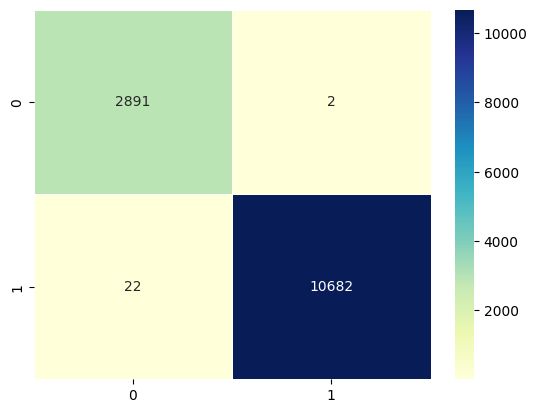

In [25]:


print(accuracy_score(all_labels, all_predictions))
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)

## Load model

In [50]:
# Load of the model after it was saved with the inference way. torch.save(model.state_dict(), PATH)
loaded_model = models.resnet18()
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 2)
loaded_model.load_state_dict( torch.load('../models/resnet18_sunny_datasets.pth'))
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Activation map